<a href="https://colab.research.google.com/github/davidguzmanr/Datos-Masivos-II/blob/main/Netflix/Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Netflix - Movie recommendation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tqdm import trange, tqdm
from itertools import chain
import warnings

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Para graficar en LaTeX, a veces da problemas, en ese caso comentar estar dos líneas
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

## Descarga

Lo más sencillo es usar la API de Kaggle.

In [2]:
import os, json, nbformat, pandas as pd

USER_ID = 'davidguzman'                          # REPLACE WITH YOUR OWN USER NAME
USER_SECRET = '7a61331a4dc397bbe9da6c0130e5ab75' # REPLACE WITH YOUR OWN PRIVATE API TOKEN

KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)

with open(os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json'), 'w') as f:
    json.dump({'username': USER_ID, 'key': USER_SECRET}, f)
    
!chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json

In [5]:
!kaggle datasets download -d netflix-inc/netflix-prize-data
!unzip netflix-prize-data.zip

netflix-prize-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  netflix-prize-data.zip
  inflating: README                  
  inflating: combined_data_1.txt     
  inflating: combined_data_2.txt     
  inflating: combined_data_3.txt     
  inflating: combined_data_4.txt     
  inflating: movie_titles.csv        
  inflating: probe.txt               
  inflating: qualifying.txt          


## Exploración y preprocesamiento

La base de datos es [Netflix - Movie recommendation](https://www.kaggle.com/laowingkin/netflix-movie-recommendation/data?select=combined_data_1.txt), en total tiene más de 17K películas, 500K usuarios y 100M de calificaciones. Mi archivo (`combined_data_1.txt`) en particular tiene

<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;
  word-break:normal;}
.tg th{background-color:#f0f0f0;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg" style="margin-left:auto;margin-right:auto;">
<thead>
  <tr>
    <th class="tg-7btt">combined_data1</th>
    <th class="tg-7btt">Estadísticas</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-abip"># usuarios</td>
    <td class="tg-abip">470,758</td>
  </tr>
  <tr>
    <td class="tg-c3ow"># películas</td>
    <td class="tg-c3ow">4,499</td>
  </tr>
  <tr>
    <td class="tg-abip"># de calificaciones</td>
    <td class="tg-abip">24,053,764</td>
  </tr>
</tbody>
</table>
<br>

Los datos tienen el siguiente formato

```cpp
1:
# User_ID, Rating, Date
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
...
4499:
# User_ID, Rating, Date
66358,3,2004-12-20
1916420,1,2004-06-27
327122,2,2005-03-03
769,3,2005-04-22
1684516,3,2005-09-25
567279,3,2004-07-12
2116703,1,2004-08-19
1722688,1,2005-02-08
```

In [7]:
data_raw = pd.read_csv('/content/combined_data_1.txt', names=['user_id', 'rating', 'date'])

In [8]:
movies = pd.read_csv('/content/movie_titles.csv', names=['movie_id', 'year', 'movie_title'], 
                     usecols=[0,1,2], encoding='latin-1')

# Nos quedamos sólo con las películas que están en mi dataset
movies = movies.loc[0:4499]

ids_to_movies = dict(zip(movies['movie_id'], movies['movie_title']))
movies_to_ids = dict(zip(movies['movie_title'], movies['movie_id']))

Ahora pasemos los datos a un dataframe para manipularlos fácilmente.

In [9]:
movies_ids_index = data_raw[data_raw['rating'].isnull()].index.tolist()
movies_ids = []

for i in trange(len(movies_ids_index) - 1):
    current_movie = movies_ids_index[i]
    next_movie = movies_ids_index[i+1]
    
    movies_ids.append([i+1]*(next_movie - current_movie - 1))
    
# Agreamos el último id
movies_ids.append([4499]*(len(data_raw) - movies_ids_index[-1] - 1))

# 'Aplanamos' la lista de listas
movies_ids = list(chain.from_iterable(movies_ids))

100%|██████████| 4498/4498 [00:00<00:00, 14031.97it/s]


Creamos nuestro dataframe limpio

In [10]:
data = data_raw[~data_raw['rating'].isnull()]
data['movie_id'] = movies_ids
data['user_id'] = data['user_id'].apply(lambda x: int(x))
data.head()

,user_id,rating,date,movie_id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


Borramos algunas variables que ya no se usarán porque ocupan bastante espacio.

In [11]:
del data_raw, movies_ids 

## Visualizaciones

In [12]:
# df = data.groupby(['movie_id']).agg(['count', 'mean']).reset_index()
# df = df.sort_values(by=[('rating', 'mean')], ascending=False)
# df['movie_id'] = df['movie_id'].replace(ids_to_movies)
# df.head(10)

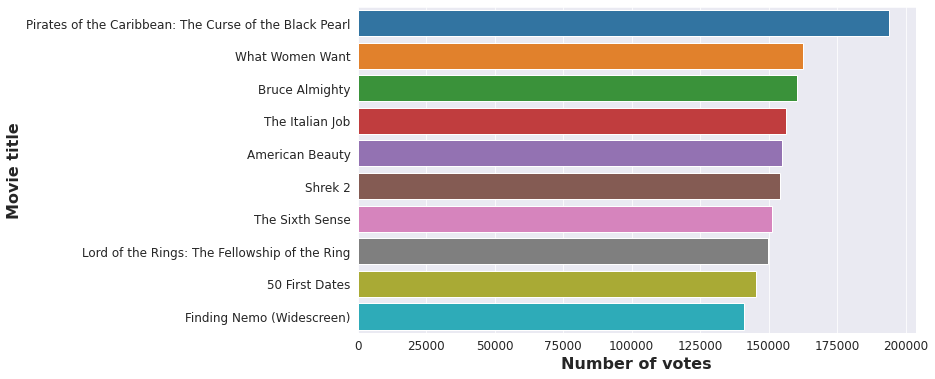

In [19]:
df = data['movie_id'].value_counts().to_frame().reset_index()
df.columns = ['movie_id', 'count']
df['movie_id'] = df['movie_id'].replace(ids_to_movies)

plt.figure(figsize=(10,6))
sns.barplot(y='movie_id', x='count', data=df.head(10))

plt.xlabel('Number of votes', size=16, fontweight='bold')
plt.ylabel('Movie title', size=16, fontweight='bold')
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

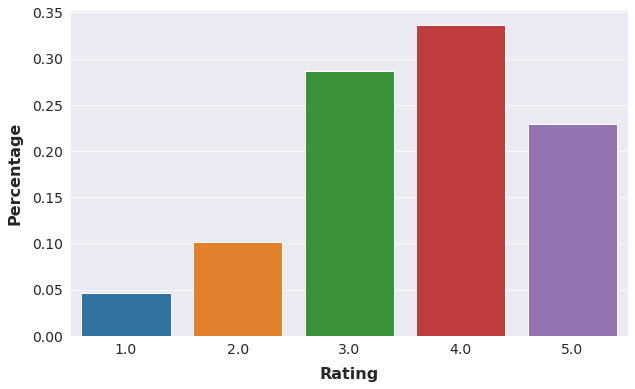

In [20]:
df = data['rating'].value_counts(normalize=True).to_frame().reset_index()
df.columns = ['rating', 'count']

plt.figure(figsize=(10,6))
sns.barplot(x='rating', y='count', data=df)

plt.xlabel('Rating', size=16, labelpad=10, fontweight='bold')
plt.ylabel('Percentage', size=16, labelpad=10, fontweight='bold')

plt.xticks(size=14)
plt.yticks(size=14)

plt.show()

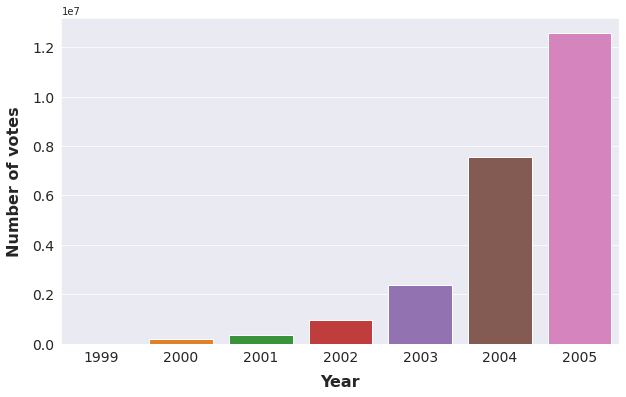

In [21]:
df = data['date'].apply(lambda x: x[0:4]).value_counts().to_frame().reset_index()
df.columns = ['year', 'count']
df = df.sort_values(by='year')

plt.figure(figsize=(10,6))
sns.barplot(x='year', y='count', data=df)

plt.xlabel('Year', size=16, labelpad=10, fontweight='bold')
plt.ylabel('Number of votes', size=16, labelpad=10, fontweight='bold')

plt.xticks(size=14)
plt.yticks(size=14)

plt.show()

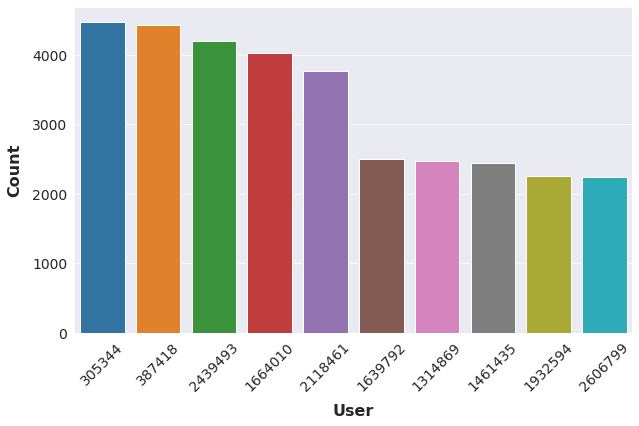

In [22]:
df = data['user_id'].value_counts().to_frame().reset_index()
df.columns = ['user_id', 'count']
df = df.sort_values(by='count', ascending=False)
df['user_id'] = df['user_id'].apply(lambda x: str(x))

plt.figure(figsize=(10,6))
sns.barplot(x='user_id', y='count', data=df.head(10))

plt.xlabel('User', size=16, labelpad=10, fontweight='bold')
plt.ylabel('Count', size=16, labelpad=10, fontweight='bold')

plt.xticks(size=14, rotation=45)
plt.yticks(size=14)

plt.show()

## Recomendador

Por como están los datos lo más lógico es usar algún método de **filtrado colaborativo**. 

Particularmente usaré [surprise](http://surpriselib.com/), la cual es una librería para sistemas de recomendación que tiene varios algoritmos. Trataré con varios de ellos (los más rápidos), haré unas pruebas con cross-validation y me quedaré con el que tenga menor error para entrenarlo con todo el dataset. 

Al final, los benchmarks quedan (tomando 1,000,000 de muestras aleatorias del dataframe original):


<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;}
.tg td{background-color:#fff;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;
  word-break:normal;}
.tg th{background-color:#f0f0f0;border-bottom-width:1px;border-color:#ccc;border-style:solid;border-top-width:1px;
  border-width:0px;color:#333;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-0vih{background-color:#f9f9f9;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-dzk6{background-color:#f9f9f9;text-align:center;vertical-align:top}
</style>
<table class="tg" style="margin-left:auto;margin-right:auto;">
<thead>
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-amwm">Mean RMSE</th>
    <th class="tg-amwm">Mean MAE</th>
    <th class="tg-amwm">Time</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0vih">SVD</td>
    <td class="tg-dzk6"><span style="font-weight:400;font-style:normal">1.0023</span></td>
    <td class="tg-dzk6"><span style="font-weight:400;font-style:normal">0.7976</span></td>
    <td class="tg-dzk6"><span style="font-weight:400;font-style:normal">2min 44s</span></td>
  </tr>
  <tr>
    <td class="tg-amwm">NMF</td>
    <td class="tg-baqh">1.1595</td>
    <td class="tg-baqh">0.9187</td>
    <td class="tg-baqh">3min 59s</td>
  </tr>
  <tr>
    <td class="tg-0vih">SlopeOne</td>
    <td class="tg-dzk6">1.1227</td>
    <td class="tg-dzk6">0.8733</td>
    <td class="tg-dzk6">33.9 s</td>
  </tr>
  <tr>
    <td class="tg-amwm">CoClustering</td>
    <td class="tg-baqh">1.1038</td>
    <td class="tg-baqh">0.8602</td>
    <td class="tg-baqh">2min 49s</td>
  </tr>
</tbody>
</table>

De modo que SVD parece ser la mejor opción.

In [24]:
!pip install scikit-surprise

In [25]:
from surprise import Reader, Dataset
from surprise import SVD, NMF, SlopeOne, KNNWithMeans, CoClustering
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from joblib import load, dump

Ahora entrenemos el recomendador con todos los datos:

In [26]:
reader = Reader(rating_scale=(1,5))

# Dataframe containing 3 columns: user ids, item ids, and ratings, in that order.
data_recommender = Dataset.load_from_df(data[['user_id', 'movie_id', 'rating']], reader=reader)
trainset = data_recommender.build_full_trainset()

# RAM goes brrrr, it barely fits
svd = SVD(random_state=42)
%time svd.fit(trainset)

CPU times: user 26min 19s, sys: 686 ms, total: 26min 20s
Wall time: 26min 24s


In [31]:
def recommend(model, user_id):
    """
    Parameters
    model: 
        Modelo entrenado de surprise.prediction_algorithms a usar para la predicción.
    user_id: int
        id del usuario.
    """
    # Le recomendaremos las cosas que más le gustaron, es decir, que lo calificó con 5
    df_user = data[(data['user_id'] == user_id) & (data['rating'] == 5)]    
    df_user['movie_title'] = df_user['movie_id'].replace(ids_to_movies)
    df_user = df_user[['movie_id', 'movie_title']]
    already_seen = df_user['movie_id'].tolist()
    
    df_recommendations = movies.copy()
    scores = df_recommendations['movie_id'].apply(lambda x: model.predict(uid=user_id, iid=x).est)    
    df_recommendations['score'] = scores
    df_recommendations = df_recommendations[~df_recommendations['movie_id'].isin(already_seen)]
    df_recommendations.sort_values(by='score', ascending=False, inplace=True)
    df_recommendations = df_recommendations[['movie_title', 'year', 'score']].reset_index(drop=True)
    
    print('Porque te gustó: {} \n'.format(df_user['movie_title'].tolist()))
    print('Te recomendamos: ')
    display(df_recommendations.head(10))

In [32]:
unique_users = data['user_id'].unique().tolist()

En el ejemplo de abajo se ve que el usuario ve únicamente series y las recomendaciones son igualmente series.

In [37]:
nice_examples = [982532, 2003078, 2241297, 2090830]

recommend(svd, 982532)

Porque te gustó: ['Sex and the City: Season 4', 'Friends: Season 2', 'The Best of Friends: Season 1', 'Friends: Season 6', 'The Best of Friends: Season 2'] 

Te recomendamos: 


,movie_title,year,score
0,Smallville: Season 1,2001.0,5.000000
1,Gilmore Girls: Season 3,2002.0,5.000000
2,Lost: Season 1,2004.0,4.938108
3,Stargate SG-1: Season 2,1998.0,4.927463
4,Angel: Season 4,2002.0,4.909250
5,Stargate SG-1: Season 3,1999.0,4.881772
6,Alias: Season 1,2001.0,4.864978
7,Star Trek: The Next Generation: Season 5,1991.0,4.859146
8,Gilmore Girls: Season 1,2000.0,4.851930
9,Firefly,2002.0,4.838316
